In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Our functions
from utils import mnist_square_grid

In [2]:
# Check if torch is running on GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: {}".format(torch.cuda.get_device_name(0)))
else:
    device = torch.device("cpu")


Running on GPU: GeForce MX150


In [3]:
# Get MNIST data
IMAGE_SIZE = 64
mnist_data = datasets.MNIST(
    root='data/mnist/', 
    download=True,
   transform=transforms.Compose([
       transforms.Resize(IMAGE_SIZE),
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
   ])
)
img_channels = 1

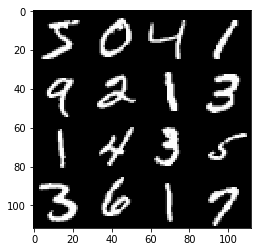

In [4]:
# Look at it!
plt.imshow(mnist_square_grid(mnist_data.data[0:16].numpy()), cmap='gray')

In [5]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, img_channels, init_channels, kernel_size=4, stride=2, padding=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(img_channels, init_channels, kernel_size, stride, padding),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(init_channels, init_channels*2, kernel_size, stride, padding),
            nn.BatchNorm2d(init_channels*2),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(init_channels*2, init_channels*4, kernel_size, stride, padding),
            nn.BatchNorm2d(init_channels*4),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(init_channels*4, init_channels*8, kernel_size, stride, padding),
            nn.BatchNorm2d(init_channels*8),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(init_channels*8, 1, 4, 1, 0),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [6]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, img_channels, target_channels, init_size, kernel_size=4, stride=2, padding=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(init_size, target_channels * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(target_channels * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(target_channels * 8, target_channels * 4, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(target_channels * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(target_channels * 4, target_channels * 2, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(target_channels * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(target_channels * 2, target_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(target_channels),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(target_channels, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output


In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [8]:
init_conv_layers = 64
noise_size = 100

In [9]:
# Create networks and apply weight initializers
disc = Discriminator(img_channels, init_conv_layers).to(device)
disc.apply(weights_init)
print(disc)

gen = Generator(img_channels, init_conv_layers, noise_size).to(device)
gen.apply(weights_init)
print(gen)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=Fa

In [10]:
loss = nn.BCELoss()

batch_size = 32
lr = 0.0002
example_noise = torch.randn(batch_size, noise_size, 1, 1)
real_label = 1
fake_label = 0

# setup optimizer
optimizer_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

Iteration: 0, D Loss: 2.5415, G Loss: 9.5169


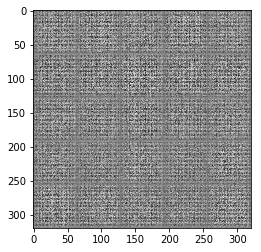

Iteration: 100, D Loss: 0.0966, G Loss: 4.6474
Iteration: 200, D Loss: 0.5748, G Loss: 4.2412
Iteration: 300, D Loss: 0.4142, G Loss: 2.9783
Iteration: 400, D Loss: 0.5012, G Loss: 2.8117
Iteration: 500, D Loss: 0.6138, G Loss: 0.9553


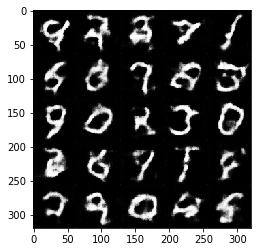

Iteration: 600, D Loss: 0.8592, G Loss: 0.9840
Iteration: 700, D Loss: 0.7367, G Loss: 1.1934
Iteration: 800, D Loss: 0.5156, G Loss: 1.8041
Iteration: 900, D Loss: 0.6906, G Loss: 2.0874
Iteration: 1000, D Loss: 0.5252, G Loss: 1.8480


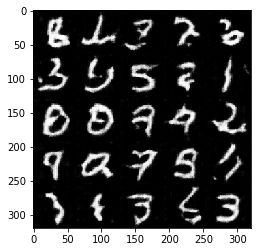

Iteration: 1100, D Loss: 0.6104, G Loss: 0.8563
Iteration: 1200, D Loss: 0.3203, G Loss: 2.9123
Iteration: 1300, D Loss: 0.5220, G Loss: 1.4162
Iteration: 1400, D Loss: 2.7035, G Loss: 7.7654
Iteration: 1500, D Loss: 1.1980, G Loss: 6.6692


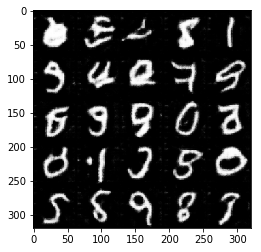

Iteration: 1600, D Loss: 0.1619, G Loss: 5.4751
Iteration: 1700, D Loss: 1.3171, G Loss: 5.8171
Iteration: 1800, D Loss: 0.2098, G Loss: 3.7421


In [11]:
loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
d_losses = []
g_losses = []
for i, data in enumerate(loader):
    ####### Discriminator error ######
    disc.zero_grad()
    
    # Get batch data
    batch = data[0].to(device)
    batch_size = batch.size(0)
    batch_labels = torch.full((batch_size,), real_label, device=device)
    
    # Real data error
    real_output = disc(batch)
    real_err = loss(real_output, batch_labels)
    real_err.backward()
    
    # Generate fake data
    noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
    fake = gen(noise)
    batch_labels.fill_(fake_label)
    
    # Fake data error
    fake_output = disc(fake.detach())
    fake_err_d = loss(fake_output, batch_labels)
    fake_err_d.backward()
    
    err_d = real_err + fake_err_d
    err_d_item = err_d.item()
    d_losses.append(err_d_item)
    optimizer_disc.step() 
    # Fake data error
    
    ###### Generator error ######
    gen.zero_grad()
    
    # Generator labels are opposite of discriminator labels
    batch_labels.fill_(real_label)
    fake_output = disc(fake)
    err_g = loss(fake_output, batch_labels)
    err_g.backward()
    err_g_item = err_g.item()
    g_losses.append(err_g_item)
    optimizer_gen.step()
    
    if i % 100 == 0:
        print(f"Iteration: {i}, D Loss: {err_d.item():.4f}, G Loss: {err_g.item():.4f}")
    
    if i % 500 == 0:
        plt.imshow(mnist_square_grid(gen(noise).detach().squeeze(1).cpu().numpy()), cmap='gray')
        plt.show()
   

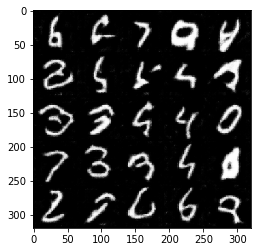

In [12]:
plt.imshow(mnist_square_grid(gen(noise).detach().squeeze(1).cpu().numpy()), cmap='gray')